In [18]:
%matplotlib ipympl
from impedance.preprocessing import readBioLogic
from impedance.models.circuits import CustomCircuit
import matplotlib.pyplot as plt
import numpy as np
from models import *
import mpmath as mp
import os
import csv
import pandas as pd
import scipy

In [19]:

# df_bks=pd.read_excel(os.path.join("..","exp data","cell setup info","Cell table stacked electrodes_BKSComments.xlsx"))
# df_bks=df_bks.dropna(subset=["Name ","Datum"])
# df_bks=df_bks.loc[df_bks["Datum"]!=float(19082018.0)]
# df_bks=df_bks.loc[df_bks["Name "]!="RM_stacked cells second DS_3+12_1"]
# df_bks

In [20]:
@element(num_params=6, units=["Ohm", "Ohm F", "Ohm F","","",""],overwrite=True)
def TLMtwoQvary(p,f):
   
    omega = 2 * np.pi * np.array(f)
    R1, R1R2, R1Q1, R2Q2, delta1, alpha = p[0], p[1], p[2], p[3], p[4], p[5]
    delta2=1-delta1
    R2=R1R2/R1
    k12=R2/R1
    wc1=1/(R1Q1)
    wc2=1/(R2Q2)
    S1=np.sqrt((omega*1j)**alpha/wc1)
    S2=np.sqrt((omega*1j)**alpha/wc2)
    C1=1/np.tanh(delta1*S1)
    C2=1/np.tanh(delta2*S2)

    Z=2*(R1)*(C1*C2*S1*k12+S2)/(S1*(C2*S1*k12+C1*S2))
    return Z

In [21]:
def find_index_of_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def lin_fun(x,a,b):
    return a*(x+b)

def find_turning_freq(f,z):
    x=np.real(z)[-6:]
    y=-np.imag(z)[-6:]
    popt, _ = scipy.optimize.curve_fit(lin_fun,x,y)
    x_intercept=popt[1]
    idx=find_index_of_nearest(np.imag(z),x_intercept)
    freq_turn=f[idx]
    return freq_turn,idx,popt[0],popt[1]

0.076103695 51
17.62744372160094 -814.0331731589696


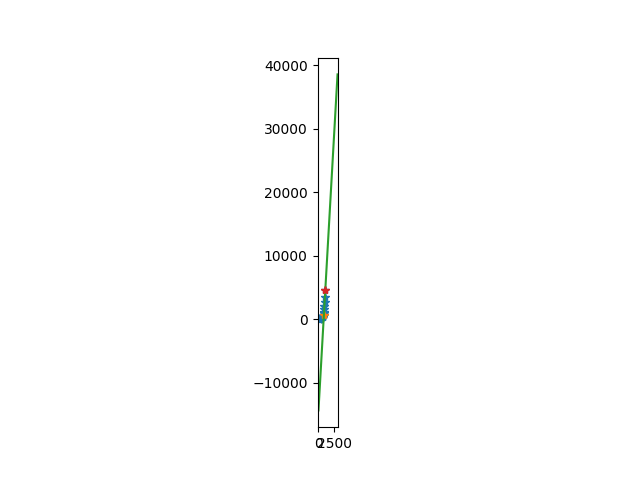

In [22]:
folder_path=os.path.join("..","exp data","EIS mpt files","two combined")
file_path=os.path.join(folder_path,"RM_stacked second run DS_3+12_1_C05.mpt")
f,z=readBioLogic(file_path)
f_turn,idx,a,b=find_turning_freq(f,z)
print(f_turn,idx)
fig, ax=plt.subplots()
ax.plot(np.real(z),-np.imag(z),"*")
ax.plot(np.real(z[idx]),-np.imag(z[idx]),"*")
xx=np.linspace(0,3000)
yy=lin_fun(xx,a,b)
ax.plot(xx,yy)
ax.set_aspect("equal")
print(a,b)
idx_l=find_index_of_nearest(f_turn/10,f)
ax.plot(np.real(z[idx_l]),-np.imag(z[idx_l]),"*")

C:\Users\admin\AppData\Local\Temp\ipykernel_19164\2151754782.py:14: RuntimeWarning: overflow encountered in tanh
  C2=1/np.tanh(delta2*S2)
C:\Users\admin\AppData\Local\Temp\ipykernel_19164\2151754782.py:13: RuntimeWarning: overflow encountered in tanh
  C1=1/np.tanh(delta1*S1)


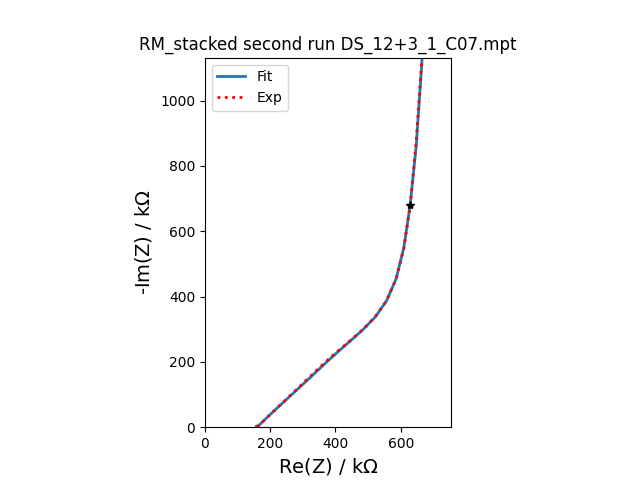

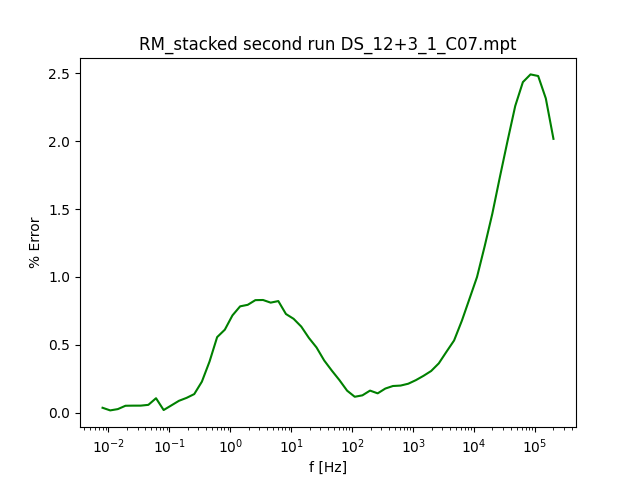

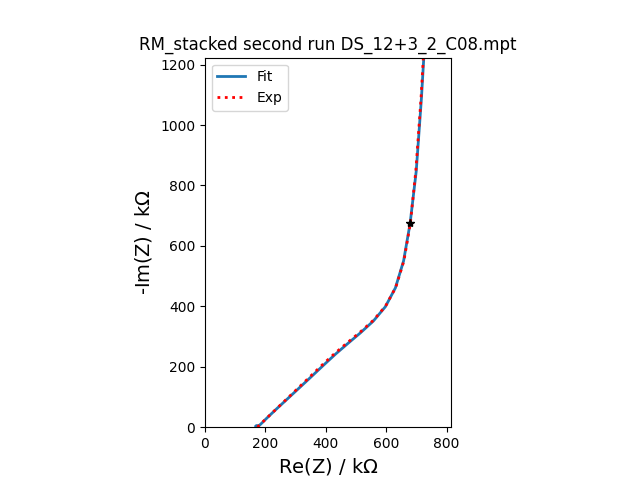

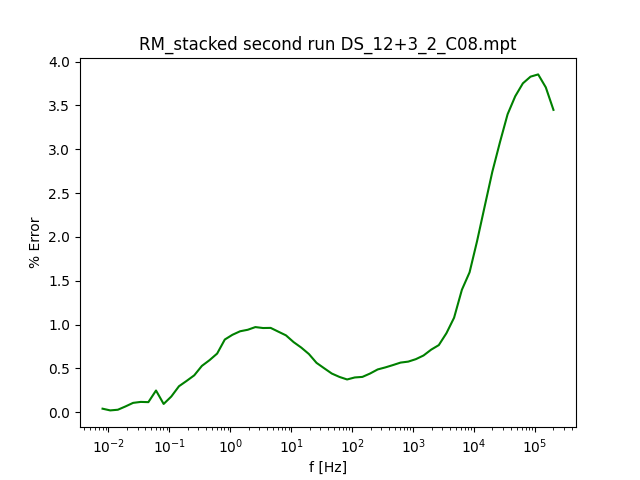

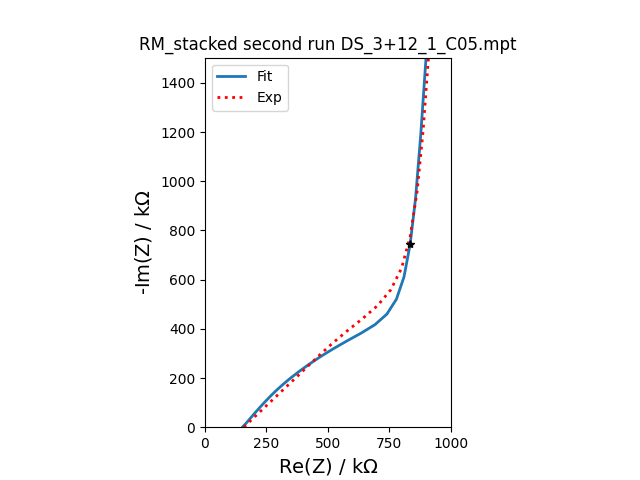

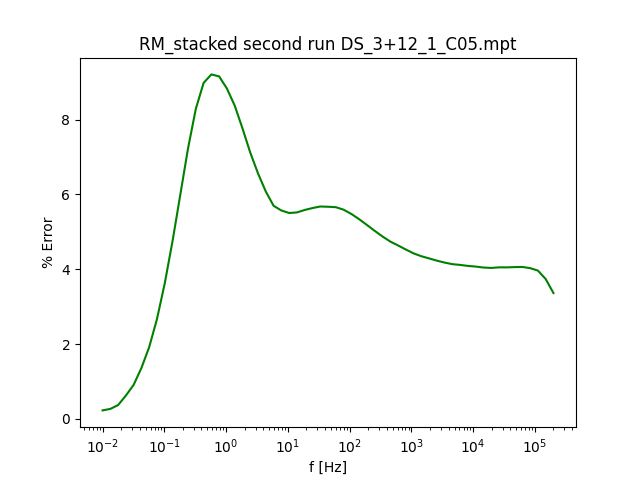

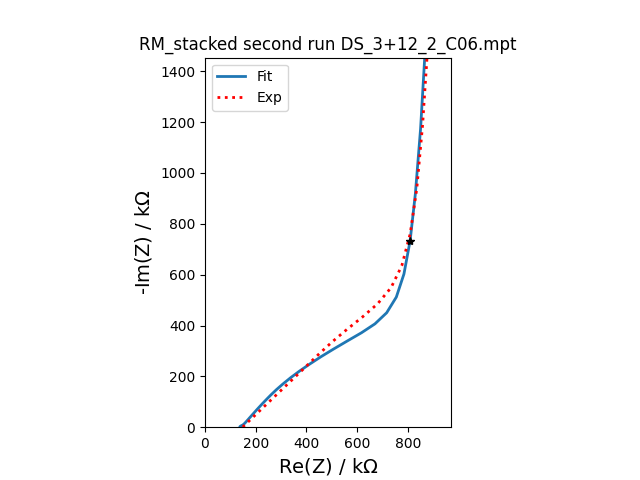

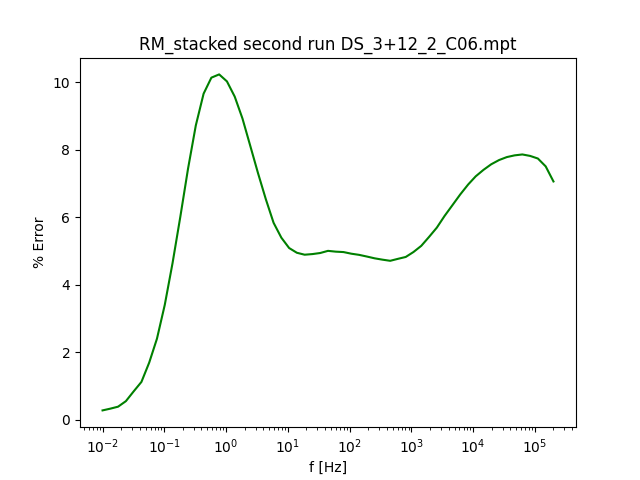

In [23]:
folder_path=os.path.join("..","exp data","EIS mpt files","two combined")
first_itr=True
for file_name in os.listdir(folder_path):
    file_path=os.path.join(folder_path,file_name)
    f,z=readBioLogic(file_path)
    
    f_orig=f
    z_orig=z

    f_turn,idx,_,_=find_turning_freq(f,z)
    idx_l=find_index_of_nearest(f_turn/10,f)

    f=f[0:idx_l+1]
    z=z[0:idx_l+1]

    Rsep=100
    R1=2000
    R2=5000
    Q1=1e-4
    Q2=3e-4
    delta=0.18
    alpha=1
    c=CustomCircuit(initial_guess=[Rsep,R1,R1*R2,R1*Q1,R2*Q2,delta,alpha],circuit="R_1-TLMtwoQvary")

    mp.dps=500
    s_mod=np.hstack((np.abs(z),np.abs(z)))
    # c.fit(impedance=z,frequencies=f,sigma=s_mod,bounds=((0,0,0,0,0,0.167,0.9),(np.inf,np.inf,np.inf,np.inf,np.inf,0.6,1)))
    c.fit(impedance=z,frequencies=f,bounds=((0,0,0,0,0,0.167,0.9),(np.inf,np.inf,np.inf,np.inf,np.inf,0.6,1)))
    
    z_fitted=c.predict(frequencies=f)
    # fcsv="../fitted parameters/two combined_mod_fit.csv"
    fcsv="../fitted parameters/two combined q vary.csv"
    
    fig, ax= plt.subplots()

    ax.set_xlabel("Re(Z) / k$\Omega$",fontsize=14)
    ax.set_ylabel("-Im(Z) / k$\Omega}$",fontsize=14)
    ax.plot(np.real(z),-np.imag(z),linewidth=2)
    ax.plot(np.real(z_fitted),-np.imag(z_fitted),linewidth=2,linestyle=":",marker="",markerfacecolor="red",color="red",ms=4)
    ax.plot(np.real(z[idx]),-np.imag(z[idx]),"*",color="black")
    ax.plot(np.real(z_orig[idx_l]),-np.imag(z_orig[idx_l]),"*")
    ax.plot(np.real(z_orig[-1]),-np.imag(z_orig[-1]),"*")
    
    ax.set_xlim(0,1.2*np.real(z[idx]))
    ax.set_ylim(0,1.8*np.real(z[idx]))

    ax.legend(["Fit","Exp"])
    ax.set_title(file_name)
    ax.set_aspect("equal")
    
    # ax.set_ylim(0,)
    fig.savefig(f"../fitted plots/two combined q vary/{file_name[:-4]}",dpi=700,bbox_inches="tight")

    fig2, ax_err =plt.subplots()
    ax_err.plot(f,100*np.abs((z-z_fitted)/z_fitted),color="green")
    # ax_err.set_ylabel(r'$|(Z_(exp)(\omega)+Z_(fit)(\omega))/Z_(fit)|$ ' , fontsize=10)
    ax_err.set_ylabel("% Error", fontsize=10)
    ax_err.set_title(file_name)
    ax_err.set_xlabel('f [Hz]', fontsize=10)
    ax_err.set_xscale('log')
    fig2.savefig(f"../fitted plots/two combined q vary/error {file_name[:-4]}",dpi=700,bbox_inches="tight")

    if first_itr:
        data=[
            ["filename","Rsep","R1","R1R2","R1Q1","R2Q2","delta","α"],
            [f"{file_name}",c.parameters_[0],c.parameters_[1],c.parameters_[2],c.parameters_[3],c.parameters_[4],c.parameters_[5],c.parameters_[6]]
        ]
        first_itr=False
        with open(fcsv,"w",newline="",encoding='UTF-8') as csv_file:
            writer=csv.writer(csv_file)
            writer.writerows(data)
    else:
        data=[
            [f"{file_name}",c.parameters_[0],c.parameters_[1],c.parameters_[2],c.parameters_[3],c.parameters_[4],c.parameters_[5],c.parameters_[6]]
        ]
        with open(fcsv,"a",newline="",encoding='UTF-8') as csv_file:
            writer=csv.writer(csv_file)
            writer.writerows(data)

In [24]:

df_bks=pd.read_excel(os.path.join("..","exp data","cell setup info","Cell table stacked electrodes_BKSComments.xlsx"))
df_bks=df_bks.dropna(subset=["Name ","Datum"])
df_bks=df_bks.loc[df_bks["Datum"]!=float(19082018.0)]
# df_bks=df_bks.loc[df_bks["Name "]!="RM_stacked cells second DS_3+12_1"]
df_bks
# ff=df_bks["Name "]
# ff!="RM_stacked cells second DS_3+12_1"



,Name,Datum,Project,m_electrode [mg],m_cc [mg],M_coating [mg],Porosity,Elyte conduct. [mS/cm],Diameter [cm],electr. thickn. [µm],cc thickness [µm],coating thickness [µm],2* Rion [Ohm] (aus EC-Lab),tau,McMullin,Comment,Masse Ref coating,Abtrag [%]
24,RM_stacked cells second S3_1,20180903.0,Stacking electrodes,26.480,0.0,26.480,0.530000,0.353,1.095,268.0,0.0,268.0,986.0,3.241013,6.115120,3.249510,6.190258,NaN
26,RM_stacked cells second S3_2,20180903.0,Stacking electrodes,27.060,0.0,27.060,0.520000,0.353,1.095,269.0,0.0,269.0,1014.0,3.258006,6.265396,NaN,NaN,NaN
28,RM_stacked cells second S12_1,20180903.0,Stacking electrodes,6.410,0.0,6.410,0.410000,0.353,1.095,52.0,0.0,52.0,417.0,5.464864,13.328938,5.392750,12.851255,NaN
30,RM_stacked cells second S12_2,20180903.0,Stacking electrodes,6.495,0.0,6.495,0.430000,0.353,1.095,54.0,0.0,54.0,402.0,5.320636,12.373573,NaN,NaN,NaN
32,RM_stacked cells second D3_1,20180903.0,Stacking electrodes,58.700,0.0,58.700,0.520000,0.353,1.095,580.0,0.0,580.0,2217.0,3.303725,6.353317,3.204987,6.163437,NaN
34,RM_stacked cells second D3_2,20180903.0,Stacking electrodes,59.840,0.0,59.840,0.520000,0.353,1.095,593.5,0.0,593.5,2133.0,3.106249,5.973556,NaN,NaN,NaN
36,RM_stacked cells second D12_1,20180903.0,Stacking electrodes,13.165,0.0,13.165,0.410000,0.353,1.095,106.0,0.0,106.0,912.0,5.863213,14.300519,6.032947,14.362681,NaN
38,RM_stacked cells second D12_2,20180903.0,Stacking electrodes,13.480,0.0,13.480,0.430000,0.353,1.095,112.0,0.0,112.0,972.0,6.202682,14.424842,NaN,NaN,NaN
40,RM_stacked cells second DS_3+12_1,20180903.0,Stacking electrodes,34.480,0.0,34.480,0.489453,0.353,1.095,329.0,0.0,329.0,1968.0,4.866345,9.942418,4.794639,9.756030,NaN
42,RM_stacked cells second DS_3+12_2,20180903.0,Stacking electrodes,34.785,0.0,34.785,0.493533,0.353,1.095,334.0,0.0,334.0,1923.0,4.722933,9.569641,NaN,NaN,NaN
